In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import embedders

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if device != torch.device("cuda"):
    sample_device = torch.device("cpu")
else:
    sample_device = device

print(f"Device: {device}, Sample Device: {sample_device}")

Device: mps, Sample Device: cpu


In [22]:
results = []

CURVATURES = [-4, -2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4]
DIM = 2
N_SAMPLES = 20
N_POINTS = 1_000
# N_POINTS = 100
N_CLASSES = 2
N_CLUSTERS = 8
MAX_DEPTH = None
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 1.0

# TASK = "regression"
TASK = "classification"
RESAMPLE_SCALES = False

SCORE = "f1-micro" if TASK == "classification" else "rmse"

my_tqdm = tqdm(total=len(CURVATURES) * N_SAMPLES)
for i, K in enumerate(CURVATURES):
    for seed in range(N_SAMPLES):
        # Ensure unique seed per trial
        seed = seed + N_SAMPLES * i
        pm = embedders.manifolds.ProductManifold(signature=[(K, DIM)], device=sample_device)

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm,
            seed=seed,
            num_points=N_POINTS,
            num_classes=N_CLASSES,
            num_clusters=N_CLUSTERS,
            cov_scale_means=COV_SCALE_MEANS / DIM,
            cov_scale_points=COV_SCALE_POINTS / DIM,
            task=TASK,
        )
        X = X.to(device)
        y = y.to(device)

        if RESAMPLE_SCALES:
            scale = 0.5 - np.random.rand() * 20
            pm.P[0].scale = torch.exp(torch.tensor(scale)).item()
            pm.P[0].manifold._log_scale = torch.nn.Parameter(torch.tensor(scale))

        # Benchmarks are now handled by the benchmark function
        accs = embedders.benchmarks.benchmark(
            X, y, pm, max_depth=MAX_DEPTH, task=TASK, score=SCORE, seed=seed, n_features="d_choose_2"
        )
        accs["curvature"] = K
        accs["seed"] = seed
        results.append(accs)

        my_tqdm.update(1)

results = pd.DataFrame(results)

  0%|          | 0/220 [00:00<?, ?it/s]

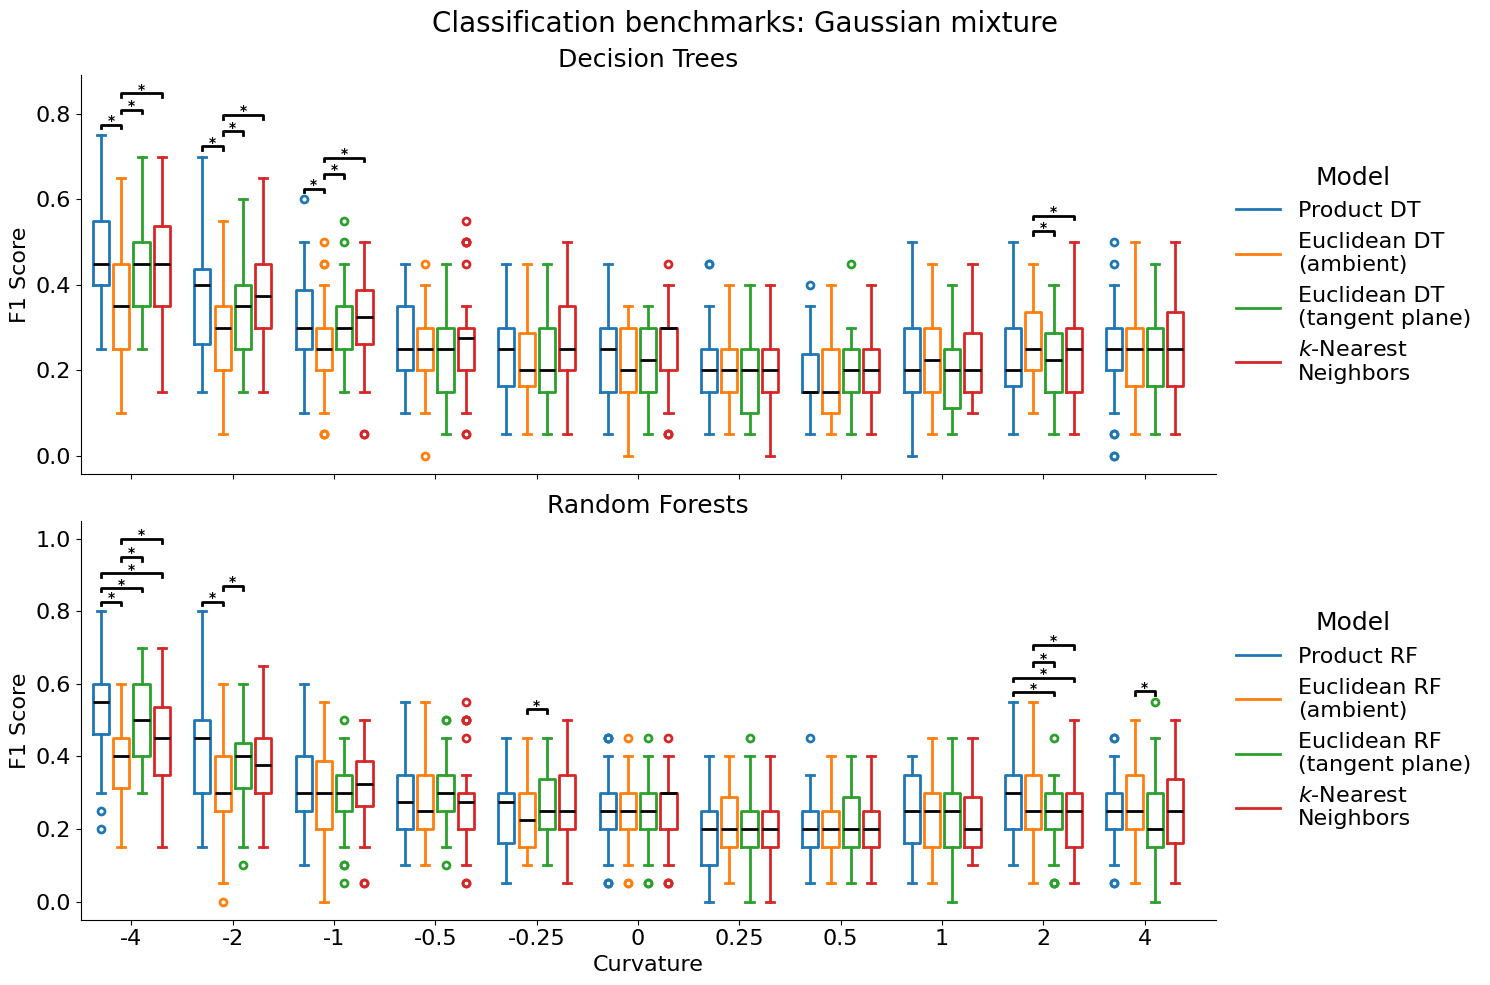

In [21]:
# Let's see the values: barplot with statistical significance annotations
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon

SIGNIFICANCE = "sig"
# SIGNIFICANCE = "ns"
CORRECTION = "bonferroni"
# CORRECTION = "none"

Y_LABEL = "F1 Score" if TASK == "classification" else "Root Mean Squared Error"


def test(x, y):
    # Check x and y are identical
    all_same = True
    for a, b in zip(x, y):
        if a != b:
            all_same = False
            break
    if all_same:
        return 1.0
    else:
        return wilcoxon(x, y).pvalue


# All the spec happens up here
models1 = ["product_dt", "sklearn_dt", "tangent_dt"]
model_names1 = ["Product DT", "Euclidean DT\n(ambient)", "Euclidean DT\n(tangent plane)"]
models2 = ["product_rf", "sklearn_rf", "tangent_rf"]
model_names2 = ["Product RF", "Euclidean RF\n(ambient)", "Euclidean RF\n(tangent plane)"]
# models3 = ["knn", "perceptron", "svm"]
# model_names3 = ["k-Nearest Neighbors", "Perceptron", "Support Vector Classifier"]
models3 = ["knn"]
model_names3 = ["$k$-Nearest\nNeighbors"]
colors = [f"C{i}" for i in range(len(models1 + models3))]

# Critical p-value depends on false discovery correction
CRITICAL_VAL = 0.05
if CORRECTION == "bonferroni":
    CRITICAL_VAL /= len(models1 + models3) * (len(models1 + models3) - 1) / 2

# Initialize plot
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
x_vals = np.arange(len(CURVATURES)) * (len(models1 + models3) + 1)

for ax, models, model_names in zip(
    axs, [models1 + models3, models2 + models3], [model_names1 + model_names3, model_names2 + model_names3]
):
    bps = []
    for i, (model, color) in enumerate(zip(models, colors)):
        # Initial boxplot
        bp = ax.boxplot(
            [results[results["curvature"] == K][model] for K in CURVATURES],
            positions=x_vals + i,
            widths=0.8,
            boxprops=dict(color=color, linewidth=2),
        )

        # Fix colors
        for element in ["boxes", "whiskers", "fliers", "means", "caps"]:
            plt.setp(bp[element], color=color, linewidth=2)
        plt.setp(bp["medians"], color="black", linewidth=2)
        plt.setp(bp["fliers"], marker="o", markersize=5, markeredgecolor=color, markeredgewidth=2)

        bps.append(bp)

    # # Flip y-axis for RMSE
    # if TASK == "regression":
    #     ax.invert_yaxis()

    # Add p-value annotations. All start at x_vals, and end at x_vals + i
    heights = [0] * len(CURVATURES)  # How many annotations per curvature
    # for i, j in [(0, 1), (1, 2), (0, 2), (0, 3), (1, 3), (2, 3)]:
    for i in range(len(models)):
        for j in range(i + 1, len(models)):
            results_K = [results[results["curvature"] == K] for K in CURVATURES]
            p_vals = [test(res[models[i]], res[models[j]]) for res in results_K]
            ymin, ymax = ax.get_ylim()
            em = ymax - ymin

            for k, p_val in enumerate(p_vals):
                if (SIGNIFICANCE == "ns" and p_val > CRITICAL_VAL) or (SIGNIFICANCE == "sig" and p_val < CRITICAL_VAL):
                    x1, x2 = x_vals[k] + i, x_vals[k] + j
                    height = results[results["curvature"] == CURVATURES[k]][models].max().max() + 0.04 * em * (
                        heights[k] + 1
                    )
                    annotation = "*" if SIGNIFICANCE == "sig" else "ns"
                    ax.text(
                        s=annotation,
                        x=(x1 + x2) / 2,
                        y=height,
                        ha="center",
                        va="center",
                        color="black",
                        fontdict={"weight": "bold"},
                    )
                    ax.plot(
                        [x1, x1, x2, x2],
                        [height - 0.02 * em, height - 0.01 * em, height - 0.01 * em, height - 0.02 * em],
                        lw=2,
                        color="black",
                    )
                    heights[k] += 1

    # Fix y-lim and remove top/right spines; make background transparent
    ax.patch.set_alpha(0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set x-ticks
    ax.set_ylabel(Y_LABEL, fontsize=16)
    ax.set_xticks(x_vals + 1.5, CURVATURES, fontsize=16)
    # ax.legend([bp["boxes"][0] for bp in bps], model_names, fontsize=14, frameon=False, title="Model")
    # Make legend to the right of the plot
    ax.legend(
        [bp["boxes"][0] for bp in bps],
        model_names,
        fontsize=16,
        frameon=False,
        title="Model",
        title_fontsize=18,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )
    ax.tick_params(axis="y", labelsize=16)
    # ax.set_yscale("log") if TASK == "regression" else None

axs[0].set_title("Decision Trees", fontsize=18)
axs[1].set_title("Random Forests", fontsize=18)
axs[1].set_xlabel("Curvature", fontsize=16)

plt.xlim(-1, len(CURVATURES) * (len(models1 + models3) + 1))
plt.suptitle(f"{TASK.capitalize()} benchmarks: Gaussian mixture", fontsize=20)

plt.tight_layout()

# Save as pdf
plt.savefig(
    f"../figures/curvature_benchmarks_{TASK}_md{MAX_DEPTH}_d{DIM}_cls{N_CLASSES}.pdf",
    bbox_inches="tight",
)
plt.show()